In [1]:
import numpy as np
import os
import cv2
import h5py
import struct
import vtk
import vtk.util
from vtk.util import numpy_support
import matplotlib.pyplot as plt
from scipy.ndimage import affine_transform, rotate, zoom, shift
from joblib import Parallel, delayed


import volume_extraction as voi
from ipywidgets import FloatProgress
from IPython.display import display

C:\Users\sarytky\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [39]:
def Orient(data, bounds):
    p = FloatProgress(min=0, max=100, description='Orienting:')
    display(p)
    
    # Get angles
    theta_x1, line_x1 = GetAngle(bounds[0], bool(0))
    p.value += 10
    theta_x2, line_x2 = GetAngle(bounds[1], bool(0))
    p.value += 10
    theta_y1, line_y1 = GetAngle(bounds[2], bool(0))
    p.value += 10
    theta_y2, line_y2 = GetAngle(bounds[3], bool(0))
    p.value += 10

    # Plot fits
    xpoints = np.linspace(-len(bounds[0])/2, len(bounds[0]) / 2, len(bounds[0]))
    plt.subplot(141); plt.plot(xpoints, bounds[0]); 
    plt.plot(xpoints, (xpoints - line_x1[2]) * (line_x1[1] / line_x1[0]) + line_x1[3], 'r--')
    plt.subplot(142); plt.plot(xpoints, bounds[1]); 
    plt.plot(xpoints, (xpoints - line_x2[2]) * (line_x2[1] / line_x2[0]) + line_x2[3], 'r--')
    plt.subplot(143); plt.plot(xpoints, bounds[2]); 
    plt.plot(xpoints, (xpoints - line_y1[2]) * (line_y1[1] / line_y1[0]) + line_y1[3], 'r--')
    plt.subplot(144); plt.plot(xpoints, bounds[3]); 
    plt.plot(xpoints, (xpoints - line_y2[2]) * (line_y2[1] / line_y2[0]) + line_y2[3], 'r--')
    plt.show()
    
    # Rotate array
    #xangle = RotationMatrix(0.5 * (theta_x1 + theta_x2), 1)
    #yangle = RotationMatrix(-0.5 * (theta_y1 + theta_y2), 0)
    #data = affine_transform(data, xangle)
    data = rotate(data, 0.5 * (theta_x1 + theta_x2), (1, 2))
    p.value += 30
    #data = affine_transform(data, yangle)
    data = rotate(data, 0.5 * (theta_y1 + theta_y2), (0, 2))
    p.value += 30
    return data

def Load(path):
    data = []
    files = os.listdir(path)
    p = FloatProgress(min=0, max=len(files), description='Loading:')
    display(p)
    
    # data coordinates
    min_x = np.zeros(len(files)); max_x = np.zeros(len(files))
    min_y = np.zeros(len(files)); max_y = np.zeros(len(files))
    
    idx = 0
    for file in files:
        f = os.path.join(path, file)
        p.value += 1
        if file.endswith('.png') and not file.endswith('spr.png'):
            try:
                # Stack images
                int(file[-5])
                i = cv2.imread(f, 0)
                data.append(i)
                
                # Bounding box
                x1, x2, y1, y2 = BoundingBox(i)
                min_x[idx] = x1; max_x[idx] = x2
                min_y[idx] = y1; max_y[idx] = y2
                idx += 1
            except ValueError:
                continue
    
    data = np.transpose(np.array(data), (1, 2, 0))
    #data = np.array(data)
    return data, (min_x, max_x, min_y, max_y)

def Save(path, fname, data):
    nfiles = np.shape(data)[2]
    
    for k in range(nfiles):
        cv2.imwrite(path + '\\' + fname + str(k).zfill(8) + '.png', data[:,:,k])

def RotationMatrix(angle, axis):
    rotate = np.identity(3)
    if axis == 0:
        rotate[1, 1] = np.cos(angle)
        rotate[2, 2] = np.cos(angle)
        rotate[1, 2] = np.sin(angle)
        rotate[2, 1] = - np.sin(angle)
    elif axis == 1:
        rotate[0, 0] = np.cos(angle)
        rotate[2, 2] = np.cos(angle)
        rotate[2, 0] = np.sin(angle)
        rotate[0, 2] = - np.sin(angle)
    elif axis == 2:
        rotate[0, 0] = np.cos(angle)
        rotate[1, 1] = np.cos(angle)
        rotate[0, 1] = np.sin(angle)
        rotate[1, 0] = - np.sin(angle)
    else:
        raise Exception('Invalid axis!')
    return rotate

def GetAngle(data, radians = bool(0)):
    # Calculate mean value
    mean = 0.0
    for k in range(len(data)):
        if data[k] > 0:
            mean += data[k] / len(data)
    
    # Centering, exclude points that are <= 0
    ypoints = []
    for k in range(len(data)):
        if data[k] > 0:
            ypoints.append(data[k] - mean)
    xpoints = np.linspace(-len(ypoints)/2, len(ypoints) / 2, len(ypoints))
    points = np.vstack([xpoints, ypoints]).transpose()
    
    # Fit line 
    vx, vy, x, y = cv2.fitLine(points, cv2.DIST_L2, 0, 0.01, 0.01)
    slope = vy / (vx + 1e-9)
    
    if radians:
        angle = np.arctan(slope)
    else:
        angle = np.arctan(slope) * 180 / np.pi
    line = (vx, vy, x, y)
    return angle, line

def BoundingBox(image, threshold = 80, max_val = 255, min_area = 1600):
    # Threshold
    _, mask = cv2.threshold(image, threshold, max_val, 0)
    # Get contours
    _, edges, _ = cv2.findContours(mask, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    if len(edges) > 0:
        bbox = (0, 0, 0, 0)
        curArea = 0
        # Iterate over every contour
        for edge in edges:
            # Get bounding box
            x, y, w, h = cv2.boundingRect(edge)
            rect = (x, y, w, h)
            #%whos
            area = w * h
            if area > curArea:
                bbox = rect
                curArea = area
        x, y, w, h = bbox
        if w * h > min_area:
            left = x; right = x + w
            top = y; bottom = y + h
        else:
            left = 0; right = 0
            top = 0; bottom = 0
    else:
        left = 0; right = 0
        top = 0; bottom = 0
    return left, right, top, bottom

def CropCenter(data, threshold = 80, size = 400):
    dims = np.shape(data)
    center = np.zeros(2)
    sumarray = np.zeros((dims[0], dims[1]))

    # Threshold & sum
    mask = data > threshold
    sumarray = mask.sum(2)
    
    # Calculate bounding box
    left, right, top, bottom = BoundingBox(np.uint8(sumarray), 1)
    
    # Get cropping limits
    center[0] = (top + bottom) / 2
    center[1] = (left + right) / 2
    x2 = np.int(np.round(np.min((center[0] + (size / 2), dims[0]))))
    x1 = np.int(np.round(np.max(x2 - size, 0)))
    y2 = np.int(np.round(np.min((center[1] + (size / 2), dims[1]))))
    y1 = np.int(np.round(np.max(y2 - size, 0)))
    
    # Calculate center pixel
    #N = 0
    #p = FloatProgress(min=0, max=dims[0], description='Get center:')
    #display(p)
    #for i in range(dims[0]):
    #    for j in range(dims[1]):
    #        if sumarray[i, j] > 0:
    #            center[0] += i
    #            center[1] += j
    #            N += 1
    #    p.value += 1 # update progress

    return data[x1:x2, y1:y2, :]

# Give string input to interface variable as 'surface' or 'bci'
# Input data should be a thresholded, cropped volume of the sample
def GetInterface(data, threshold, size, choice = 'surface'):
    p = FloatProgress(min=0, max=size[0], description='Get interface:')
    display(p)
    dims = np.shape(data)
    if dims[0] != size[0] or dims[1] != size[0]:
        raise Exception('Sample and voi size are incompatible!')
    interface = np.zeros((dims[0], dims[1]))
    voi = np.zeros((dims[0], dims[1], size[1]))
    
    # Threshold data
    if choice == 'surface':
        surfvoi = voi
        mask = data > threshold
    elif choice == 'bci':
        deepvoi = voi; ccvoi = voi
        # Load mask
        # Threshold using mask
        mask = data * mask
    else:
        raise Exception('Select an interface to be extracted!')
        
    #Get interface
    interface = np.argmax(((data * mask)>threshold)*1.0, 2)
    
    # Get coordinates
    for x in range(size[0]):
        for y in range(size[0]):
            #for z in range(dims[2]):
            #    if mask[x, y, z] > 0:
            #        interface[x, y] = z
            #        break
            depth = np.uint(interface[x, y]); #print(depth)
            zlim = np.uint(depth + size[1]); #print(zlim)
            if choice == 'surface':
                surfvoi[x, y, :] = data[x, y, depth:zlim]
            elif choice == 'bci':
                deepvoi[x, y, :] = data[x, y, depth-size[1]:depth]
                ccvoi[x, y, :] = data[x, y, depth:zlim]
            else:
                raise Exception('Select an interface to be extracted!')
        p.value += 1
    print(interface)
    if choice == 'surface':
        return surfvoi, interface
    if choice == 'bci':
        return deepvoi, ccvoi, interface
    
def PrintOrthogonal(data):
    dims = np.array(np.shape(data))
    for i in range(len(dims)):
        dims[i] =  np.int(np.round(dims[i] / 2))
    
    plt.subplot(131)
    plt.imshow(data[:,:,dims[2]])
    plt.subplot(132)
    plt.imshow(data[:,dims[1],:])
    plt.subplot(133)
    plt.imshow(data[dims[0],:,:])
    plt.show()
    
def SaveOrthogonal(path, data):
    dims = np.array(np.shape(data))
    for i in range(len(dims)):
        dims[i] =  np.int(np.round(dims[i] / 2))
    
    fig = plt.figure(dpi=180)
    plt.subplot(131)
    plt.imshow(data[:,:,dims[2]], cmap='gray')
    plt.title('Transaxial')
    plt.subplot(132)
    plt.imshow(data[:,dims[1],:], cmap='gray')
    plt.title('Coronal')
    plt.subplot(133)
    plt.imshow(data[dims[0],:,:], cmap='gray')
    plt.title('Sagittal')
    fig.savefig(path)
    #plt.gcf().clear()
    plt.close()
    
def writebinaryimage(path, image, dtype):
    with open(path, "wb") as f:
        f.write(struct.pack('<i', image.shape[0])) # Width
        # Image values as float
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                if dtype == 'float':
                    f.write(struct.pack('<f', image[i, j]))
                if dtype == 'double':
                    f.write(struct.pack('<d', image[i, j]))
                if dtype == 'int':
                    f.write(struct.pack('<i', image[i, j]))                    
    return True

def Pipeline(path, sample, savepath, threshold, size):
    print('1. Load sample')
    data, bounds = Load(path)
    PrintOrthogonal(data)
    SaveOrthogonal(savepath + "\\Images\\" + sample + "_input.png", data)

    # Orient array
    print('2. Orient sample')
    data = Orient(data, bounds)
    PrintOrthogonal(data)
    SaveOrthogonal(savepath + "\\Images\\" + sample + "_orient.png", data)

    # Flip and crop volume
    print('3. Crop and flip center volume:')
    data = CropCenter(data, threshold, size[0])
    data = np.flip(data, 2)
    PrintOrthogonal(data)
    SaveOrthogonal(savepath + "\\Images\\" + sample + "_orient_cropped.png", data)
    

    print('4. Get interface coordinates:')
    surfvoi, interface = GetInterface(data, threshold, size, 'surface')
    PrintOrthogonal(surfvoi)
    SaveOrthogonal(savepath + "\\Images\\" + sample + "_surface.png", surfvoi)

    print('5. Save mean and std images')
    mean = np.mean(surfvoi, 2)
    std = np.std(surfvoi, 2)
    plt.imshow(mean)
    plt.imshow(std)
    plt.show()
    cv2.imwrite(savepath + "\\Images\\" + sample + "_surface_mean.png", 
                ((mean - np.min(mean)) / (np.max(mean) - np.min(mean)) * 255))
    cv2.imwrite(savepath + "\\Images\\" + sample + "_surface_std.png",
                ((std - np.min(std)) / (np.max(std) - np.min(std)) * 255))

    writebinaryimage(savepath + "\\" + sample + '_mean.dat', mean, 'double')
    writebinaryimage(savepath + "\\" + sample + '_std.dat', std, 'double')

In [7]:
# Parameters
threshold = 80
size = [100, 20] # width, depth

# Load array
impath = r"Z:\3DHistoData\rekisteroidyt"
path = r"C:\Users\sarytky\Desktop\15_L6TL_2_PTA_48h_Rec\15_L6TL_2_PTA_48h_Rec\Binned"
#path = r"C:\Users\sarytky\Desktop\15_L6TL_2_PTA_48h_Rec\21_L3L_binned"
savepath = r"Z:\3DHistoData\SurfaceImages"
sample = '15_L6TL_2'

files = os.listdir(impath)
files.sort()

for k in range(2, len(files), 4):
    try:
        file = os.listdir(impath + "\\" + files[k] + "\\" + "Registration" )
        pth = impath + "\\" + files[k] + "\\" + "Registration"
    except FileNotFoundError:
        try:
            file = os.listdir(impath + "\\" + files[k] + "\\" + files[k] + "\\" + "Registration" )
            pth = impath + "\\" + files[k] + "\\" + files[k] + "\\" + "Registration"
        except FileNotFoundError:
            continue
    print("Prosessing file: " + str(files[k]))
    Pipeline(pth, files[k], savepath, threshold, size)

Prosessing file: 13_R3L_2_PTA_48h_Rec
1. Load sample


FloatProgress(value=0.0, description='Loading:', max=1293.0)

KeyboardInterrupt: 

1. Load sample


FloatProgress(value=0.0, description='Loading:', max=419.0)

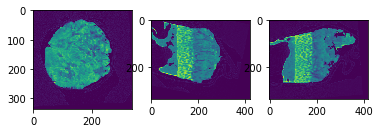

2. Orient sample


FloatProgress(value=0.0, description='Orienting:')

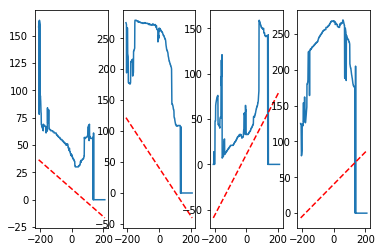

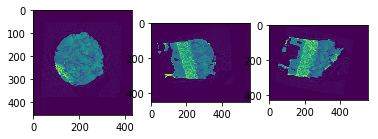

3. Crop and flip center volume:


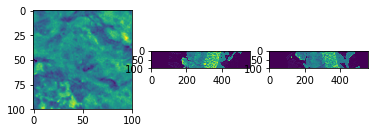

4. Get interface coordinates:


FloatProgress(value=0.0, description='Get interface:')

[[200 197 197 ... 219 220 221]
 [198 197 197 ... 219 220 220]
 [198 196 198 ... 219 219 220]
 ...
 [146 147 148 ... 226 227 228]
 [147 148 148 ... 226 227 228]
 [148 148 149 ... 225 227 228]]


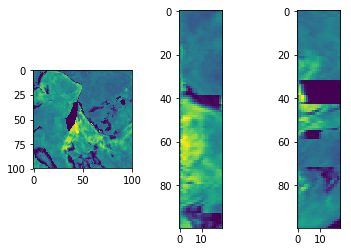

5. Save mean and std images


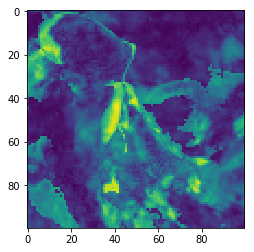

In [40]:
# Load array
impath = r"Z:\3DHistoData\rekisteroidyt"
path = r"C:\Users\sarytky\Desktop\15_L6TL_2_PTA_48h_Rec\15_L6TL_2_PTA_48h_Rec\Binned"
#path = r"C:\Users\sarytky\Desktop\15_L6TL_2_PTA_48h_Rec\21_L3L_binned"
savepath = r"Z:\3DHistoData\SurfaceImages"
sample = '15_L6TL_2'

Pipeline(path, sample, savepath, threshold, size)


In [53]:
writebinaryimage(savepath + "\\" + sample + '_mean.dat', mean, 'double')
writebinaryimage(savepath + "\\" + sample + '_std.dat', std, 'double')

True

In [9]:
import vtk
from numpy import *
 
# We begin by creating the data we want to render.
# For this tutorial, we create a 3D-image containing three overlaping cubes.
# This data can of course easily be replaced by data from a medical CT-scan or anything else three dimensional.
# The only limit is that the data must be reduced to unsigned 8 bit or 16 bit integers.
data_matrix = np.uint8(data)
 
# For VTK to be able to use the data, it must be stored as a VTK-image. This can be done by the vtkImageImport-class which
# imports raw data and stores it.
dataImporter = vtk.vtkImageImport()
# The preaviusly created array is converted to a string of chars and imported.
data_string = data_matrix.tostring()
dataImporter.CopyImportVoidPointer(data_string, len(data_string))
# The type of the newly imported data is set to unsigned char (uint8)
dataImporter.SetDataScalarTypeToUnsignedChar()
# Because the data that is imported only contains an intensity value (it isnt RGB-coded or someting similar), the importer
# must be told this is the case.
dataImporter.SetNumberOfScalarComponents(1)
# The following two functions describe how the data is stored and the dimensions of the array it is stored in. For this
# simple case, all axes are of length 75 and begins with the first element. For other data, this is probably not the case.
# I have to admit however, that I honestly dont know the difference between SetDataExtent() and SetWholeExtent() although
# VTK complains if not both are used.
dataImporter.SetDataExtent(0, 74, 0, 74, 0, 74)
dataImporter.SetWholeExtent(0, 74, 0, 74, 0, 74)
 
# The following class is used to store transparencyv-values for later retrival. In our case, we want the value 0 to be
# completly opaque whereas the three different cubes are given different transperancy-values to show how it works.
alphaChannelFunc = vtk.vtkPiecewiseFunction()
alphaChannelFunc.AddPoint(0, 0.0)
alphaChannelFunc.AddPoint(50, 0.05)
alphaChannelFunc.AddPoint(100, 0.1)
alphaChannelFunc.AddPoint(150, 0.2)
 
# This class stores color data and can create color tables from a few color points. For this demo, we want the three cubes
# to be of the colors red green and blue.
colorFunc = vtk.vtkColorTransferFunction()
colorFunc.AddRGBPoint(50, 1.0, 0.0, 0.0)
colorFunc.AddRGBPoint(100, 0.0, 1.0, 0.0)
colorFunc.AddRGBPoint(255, 0.0, 0.0, 1.0)
 
# The preavius two classes stored properties. Because we want to apply these properties to the volume we want to render,
# we have to store them in a class that stores volume prpoperties.
volumeProperty = vtk.vtkVolumeProperty()
volumeProperty.SetColor(colorFunc)
volumeProperty.SetScalarOpacity(alphaChannelFunc)
 
# We can finally create our volume. We also have to specify the data for it, as well as how the data will be rendered.
volumeMapper = vtk.vtkFixedPointVolumeRayCastMapper()
volumeMapper.SetInputConnection(dataImporter.GetOutputPort())
 
# The class vtkVolume is used to pair the preaviusly declared volume as well as the properties to be used when rendering that volume.
volume = vtk.vtkVolume()
volume.SetMapper(volumeMapper)
volume.SetProperty(volumeProperty)
 
# With almost everything else ready, its time to initialize the renderer and window, as well as creating a method for exiting the application
renderer = vtk.vtkRenderer()
renderWin = vtk.vtkRenderWindow()
renderWin.AddRenderer(renderer)
renderInteractor = vtk.vtkRenderWindowInteractor()
renderInteractor.SetRenderWindow(renderWin)
 
# We add the volume to the renderer ...
renderer.AddVolume(volume)
# ... set background color to white ...
renderer.SetBackground(0,0,0)
# ... and set window size.
renderWin.SetSize(400, 400)
 
# A simple function to be called when the user decides to quit the application.
def exitCheck(obj, event):
    if obj.GetEventPending() != 0:
        obj.SetAbortRender(1)
 
# Tell the application to use the function as an exit check.
renderWin.AddObserver("AbortCheckEvent", exitCheck)
 
renderInteractor.Initialize()
# Because nothing will be rendered without any input, we order the first render manually before control is handed over to the main-loop.
renderWin.Render()
renderInteractor.Start()

In [32]:
img = data[:,:,100]
#plt.imshow(img)
cv2.line(img,(0,0),(511,511),(255,255,255),30)
plt.show()


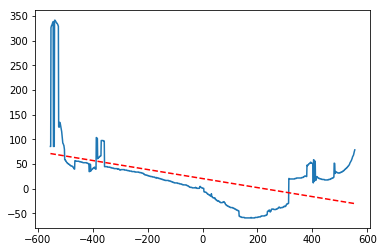

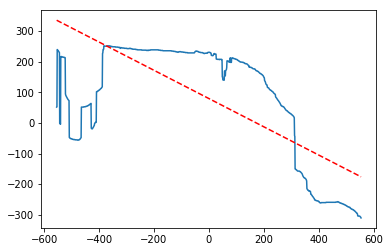

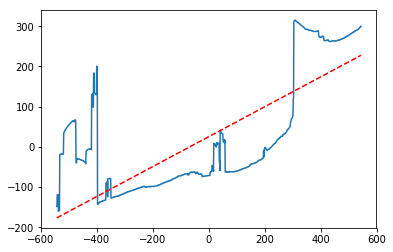

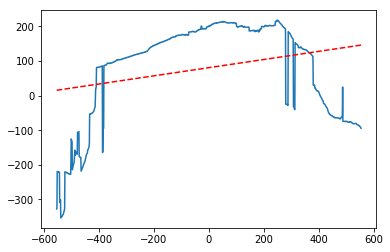

[array([-5.2302876], dtype=float32), array([-24.756908], dtype=float32), array([20.384657], dtype=float32), array([6.7094574], dtype=float32)]
[array([0.99315137], dtype=float32), array([0.11683467], dtype=float32), array([0.], dtype=float32), array([80.65382], dtype=float32)]


TypeError: Layout of the output array img is incompatible with cv::Mat (step[ndims-1] != elemsize or step[1] != elemsize*nchannels)

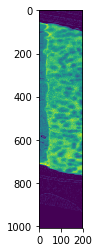

In [56]:
# Get angles
theta_x1, line_x1 = GetAngle(bounds[0], bool(0))
theta_x2, line_x2 = GetAngle(bounds[1], bool(0))
theta_y1, line_y1 = GetAngle(bounds[2], bool(0))
theta_y2, line_y2 = GetAngle(bounds[3], bool(0))
print([theta_x1, theta_x2, theta_y1, theta_y2])
# Plot lines
dims = np.array(np.shape(data))
dims2 = np.array(np.shape(data))
for i in range(len(dims)):
    dims[i] =  np.int(np.round(dims[i] / 2))
cor = data[:,dims[1],:]
sag = data[dims[0],:,:]

[vx, vy, x, y] = line_y2
print([vx, vy, x, y])

lefty = int((-x*vy/vx) + y)
righty = int(((dims2[0]-x)*vy/vx)+y)
#%whos
plt.subplot(121)
plt.imshow(cor)
righty = int(((np.shape(cor)[0]-x)*vy/vx)+y)
point1 = (np.shape(cor)[0]-1,righty)
cv2.line(cor, (np.shape(cor)[0]-1,righty),(0,lefty),(255,255,255),30)

plt.subplot(122)
plt.imshow(sag)
righty = int(((np.shape(sag)[0]-x)*vy/vx)+y)
cv2.line(sag, (np.shape(sag)[0]-1,righty),(0,lefty),(255,255,255),30)
plt.show()

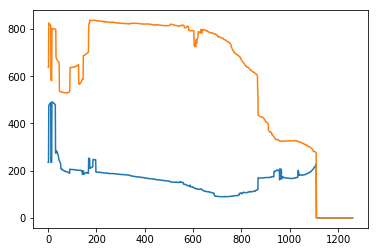

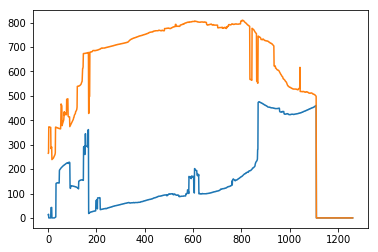

In [23]:
plt.plot(np.linspace(1, 1260, 1260), min_x)
plt.plot(np.linspace(1, 1260, 1260), max_x)
plt.show()
plt.plot(np.linspace(1, 1260, 1260), min_y)
plt.plot(np.linspace(1, 1260, 1260), max_y)
plt.show()

### VTK processing

In [ ]:
def ArrayToVTK(A):
    imagedata = vtk.vtkImageData()
    depthArray = numpy_support.numpy_to_vtk(A.ravel(), deep=True, array_type=vtk.VTK_UNSIGNED_CHAR)
    imagedata.SetDimensions(A.shape)
    imagedata.SetOrigin(0,0,0)
    imagedata.GetPointData().SetScalars(depthArray)
    return imagedata

def VTKToArray(vtkdata, shape):
    array = numpy_support.vtk_to_numpy(vtkdata)
    array = array.reshape(shape)
    return array

def RotateVTK(vtkdata, angles):
    # Initialize
    mapper = vtk.vtkFixedPointVolumeRayCastMapper()
    mapper.SetInputData(vtkdata)
    actor = vtk.vtkActor()

    cx, cy, cz = actor.GetCenter()

    transf = vtk.vtkTransform()
    transf.Translate(cx, cy, cz)
    transf.RotateX(angles[0])
    transf.RotateY(angles[1])
    transf.RotateZ(angles[2])
    transf.Translate(-cx, -cy, -cz)
    
    slicer = vtk.vtkImageReslice()
    slicer.SetInputData(vtkdata)
    slicer.Set

    return vtkdata

def InitializeVTK():
    ren = vtk.vtkRenderer()
    renWin = vtk.vtkRenderWindow()
    renWin.AddRenderer(ren)
    iren = vtk.vtkRenderWindowInteractor()
    iren.SetRenderWindow(renWin)
    
    alphaChannelFunc = vtk.vtkPiecewiseFunction()
    alphaChannelFunc.AddPoint(0, 0.0)
    alphaChannelFunc.AddPoint(50, 0.05)
    alphaChannelFunc.AddPoint(100, 0.1)
    alphaChannelFunc.AddPoint(150, 0.2)

    # This class stores color data and can create color tables from a few color points. For this demo, we want the three cubes
    # to be of the colors red green and blue.
    colorFunc = vtk.vtkColorTransferFunction()
    colorFunc.AddRGBPoint(50, 1.0, 0.0, 0.0)
    colorFunc.AddRGBPoint(100, 0.0, 1.0, 0.0)
    colorFunc.AddRGBPoint(150, 0.0, 0.0, 1.0)
    return

def Render(vtkimagedata):
    # The following class is used to store transparencyv-values for later retrival. In our case, we want the value 0 to be
    # completly opaque whereas the three different cubes are given different transperancy-values to show how it works.
    alphaChannelFunc = vtk.vtkPiecewiseFunction()
    alphaChannelFunc.AddPoint(0, 0.0)
    alphaChannelFunc.AddPoint(50, 0.05)
    alphaChannelFunc.AddPoint(100, 0.1)
    alphaChannelFunc.AddPoint(150, 0.2)

    # This class stores color data and can create color tables from a few color points. For this demo, we want the three cubes
    # to be of the colors red green and blue.
    colorFunc = vtk.vtkColorTransferFunction()
    colorFunc.AddRGBPoint(50, 1.0, 0.0, 0.0)
    colorFunc.AddRGBPoint(100, 0.0, 1.0, 0.0)
    colorFunc.AddRGBPoint(150, 0.0, 0.0, 1.0)

    # The previous two classes stored properties. Because we want to apply these properties to the volume we want to render,
    # we have to store them in a class that stores volume prpoperties.
    volumeProperty = vtk.vtkVolumeProperty()
    volumeProperty.SetColor(colorFunc)
    volumeProperty.SetScalarOpacity(alphaChannelFunc)

    # This class describes how the volume is rendered (through ray tracing).
    compositeFunction = vtk.vtkVolumeRayCastCompositeFunction()
    # We can finally create our volume. We also have to specify the data for it, as well as how the data will be rendered.
    volumeMapper = vtk.vtkVolumeRayCastMapper()
    volumeMapper.SetVolumeRayCastFunction(compositeFunction)
    volumeMapper.SetInputConnection(vtkimagedata.GetOutputPort())

    # The class vtkVolume is used to pair the preaviusly declared volume as well as the properties to be used when rendering that volume.
    volume = vtk.vtkVolume()
    volume.SetMapper(volumeMapper)
    volume.SetProperty(volumeProperty)

    # With almost everything else ready, its time to initialize the renderer and window, as well as creating a method for exiting the application
    renderer = vtk.vtkRenderer()
    renderWin = vtk.vtkRenderWindow()
    renderWin.AddRenderer(renderer)
    renderInteractor = vtk.vtkRenderWindowInteractor()
    renderInteractor.SetRenderWindow(renderWin)

    # We add the volume to the renderer ...
    renderer.AddVolume(volume)
    # ... set background color to white ...
    renderer.SetBackground(0,0,0)
    # ... and set window size.
    renderWin.SetSize(400, 400)

    # A simple function to be called when the user decides to quit the application.
    def exitCheck(obj, event):
        if obj.GetEventPending() != 0:
            obj.SetAbortRender(1)

    # Tell the application to use the function as an exit check.
    renderWin.AddObserver("AbortCheckEvent", exitCheck)

    renderInteractor.Initialize()
    # Because nothing will be rendered without any input, we order the first render manually before control is handed over to the main-loop.
    renderWin.Render()
    renderInteractor.Start()
    return

In [ ]:
array = data[:,:,:]
shape = np.shape(array)
vtkdata = ArrayToVTK(array)
Render(vtkdata)
vtkdata = RotateVTK(vtkdata, [90,0,0])
array2 = VTKToArray(vtkdata, shape)
PrintOrthogonal(array)
PrintOrthogonal(array2 - array)

In [ ]:
import h5py

savepath = r"C:\Users\sarytky\Desktop\15_L6TL_2_PTA_48h_Rec\15_L6TL_2_PTA_48h_Rec\Saved"
h5 = h5py.File('filename.h5','w')
h5.create_dataset('mean',data=mean)
h5.create_dataset('std',data=std)
h5.close()

h5 = h5py.File('filename.h5','r')
mean = h5['mean'][:]
h5.close()